In [1]:
import numpy as np
import pandas as pd
import numba
from formatting_data import get_data_frame
from functions import draw_x_gametimes, draw_history, draw_log_history

In [2]:
df, game_df = get_data_frame(6000000) #game_df used for identifying game using game_id

In [3]:
#creating utility matrix
utility_matrix = df.pivot_table(index=df.columns[0], columns=df.columns[1], values=df.columns[2], fill_value=0)
utility_matrix = utility_matrix.to_numpy(dtype=np.float32)

In [4]:
#R matrix for checking if the player has played the game
R = (utility_matrix != 0).astype(int)

In [5]:
num_features = 100
np.random.seed(9)

#initialising users and items features randomly
user_matrix = np.random.uniform(0,1,(utility_matrix.shape[0], num_features))
item_matrix = np.random.uniform(0,1,(utility_matrix.shape[1], num_features))
user_matrix = np.float32(user_matrix)
item_matrix = np.float32(item_matrix)

In [6]:
@numba.njit
def cost(y, pred, theta, X, R, lambda_, chunk_size=500):
    cost = (np.sum(theta ** 2) + np.sum(X ** 2)) * lambda_
    for i in range(0, y.shape[0], chunk_size):
        cost += np.sum(
                np.square(
                np.subtract(y[i:i+chunk_size], pred[i:i+chunk_size] * R[i:i+chunk_size])
            )
        )
    return cost/2

In [7]:
#gradient descent
@numba.jit(nopython=True, parallel=True)
def gradient_descent(utilmat, theta, X, R, iterations, alpha, lambda_, cost_func):
    history = []
    
    for i in range(iterations):
        pred = theta @ X.T
        error = (utilmat - pred * R)

        dj_dx = error.T @ theta
        dj_dx += lambda_ * dj_dx
        dj_dx *= alpha

        dj_dtheta = error @ X
        dj_dtheta += lambda_ * dj_dtheta
        dj_dtheta *= alpha

        theta += dj_dtheta
        X += dj_dx

        if i % (iterations // 25) == 0: 
            J = cost_func(utilmat, pred, theta, X, R, lambda_)
            history.append(J)
        if i % (iterations // 10) == 0:
            print(f'Iteration: {i}, cost: ')
            print(J)
        
    return theta, X, history

In [8]:
alpha = 0.00000001
lambda_ = 0.01
iterations = 500

In [9]:
user_matrix, item_matrix, history = gradient_descent(utility_matrix, user_matrix, item_matrix, R, iterations, alpha, lambda_, cost)

Iteration: 0, cost: 
77031281276197.25
Iteration: 50, cost: 
51303758585496.82
Iteration: 100, cost: 
47144319997661.8
Iteration: 150, cost: 
43644318242304.22
Iteration: 200, cost: 
35765809378396.16
Iteration: 250, cost: 
33366253062713.64
Iteration: 300, cost: 
28360832996495.66
Iteration: 350, cost: 
26223053193564.66
Iteration: 400, cost: 
23045060389398.4
Iteration: 450, cost: 
21106217140096.16


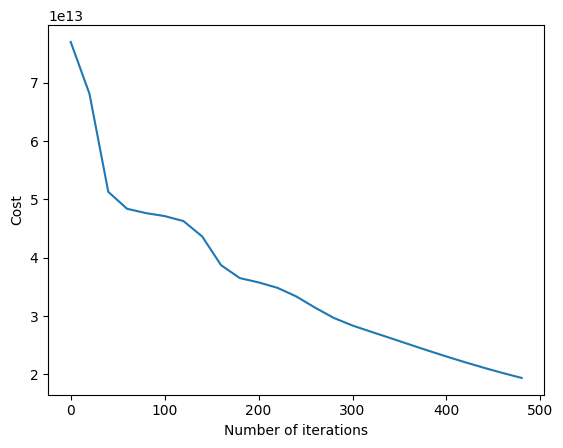

In [17]:
draw_history(range(0, iterations, iterations//25), history)

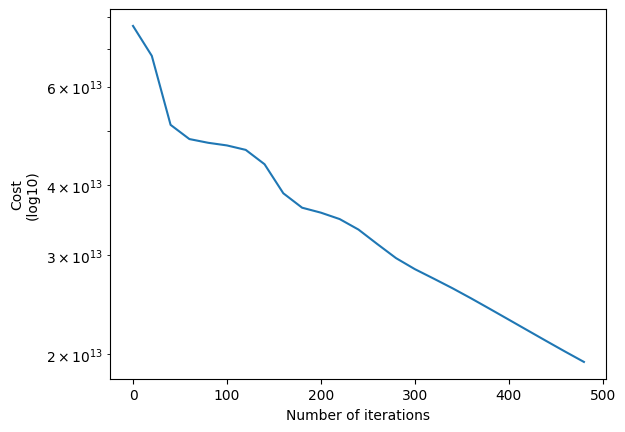

In [18]:
draw_log_history(range(0, iterations, iterations//25), history)

In [33]:
np.savetxt('model_matrices/user.txt', user_matrix)
np.savetxt('model_matrices/item.txt', item_matrix)

In [3]:
user_matrix = np.loadtxt('model_matrices/user.txt')
item_matrix = np.loadtxt('model_matrices/item.txt')

In [4]:
u_id = 62500
num_games = 20

In [5]:
user = df.loc[df.user_id == u_id].sort_values(by='playtime', ascending=False).head(num_games)[['game_id', 'playtime']]
user_games = game_df.set_index(game_df.game_id).loc[user.game_id, 'game_name']
user_playtimes = user[['game_id', 'playtime']]
user_playtimes.playtime = user_playtimes.playtime.div(60)
actual_top_games = pd.merge(user_games, user_playtimes, on=['game_id'])

pred = user_matrix[u_id] @ item_matrix.T
top = np.sort(pred)[-num_games:]
topi = np.where(np.isin(pred, top))

time_df = pd.DataFrame({'game_id': np.array(topi).flatten(), 'predicted_playtime': pred[topi].flatten()})
time_df.predicted_playtime = time_df.predicted_playtime.div(60)
pred_top_games = pd.merge(game_df.iloc[topi], time_df, on=['game_id'])
pred_top_games  = pred_top_games.sort_values(ascending=False, by=['predicted_playtime'])
pred_top_games  = pred_top_games.reset_index(drop=True)

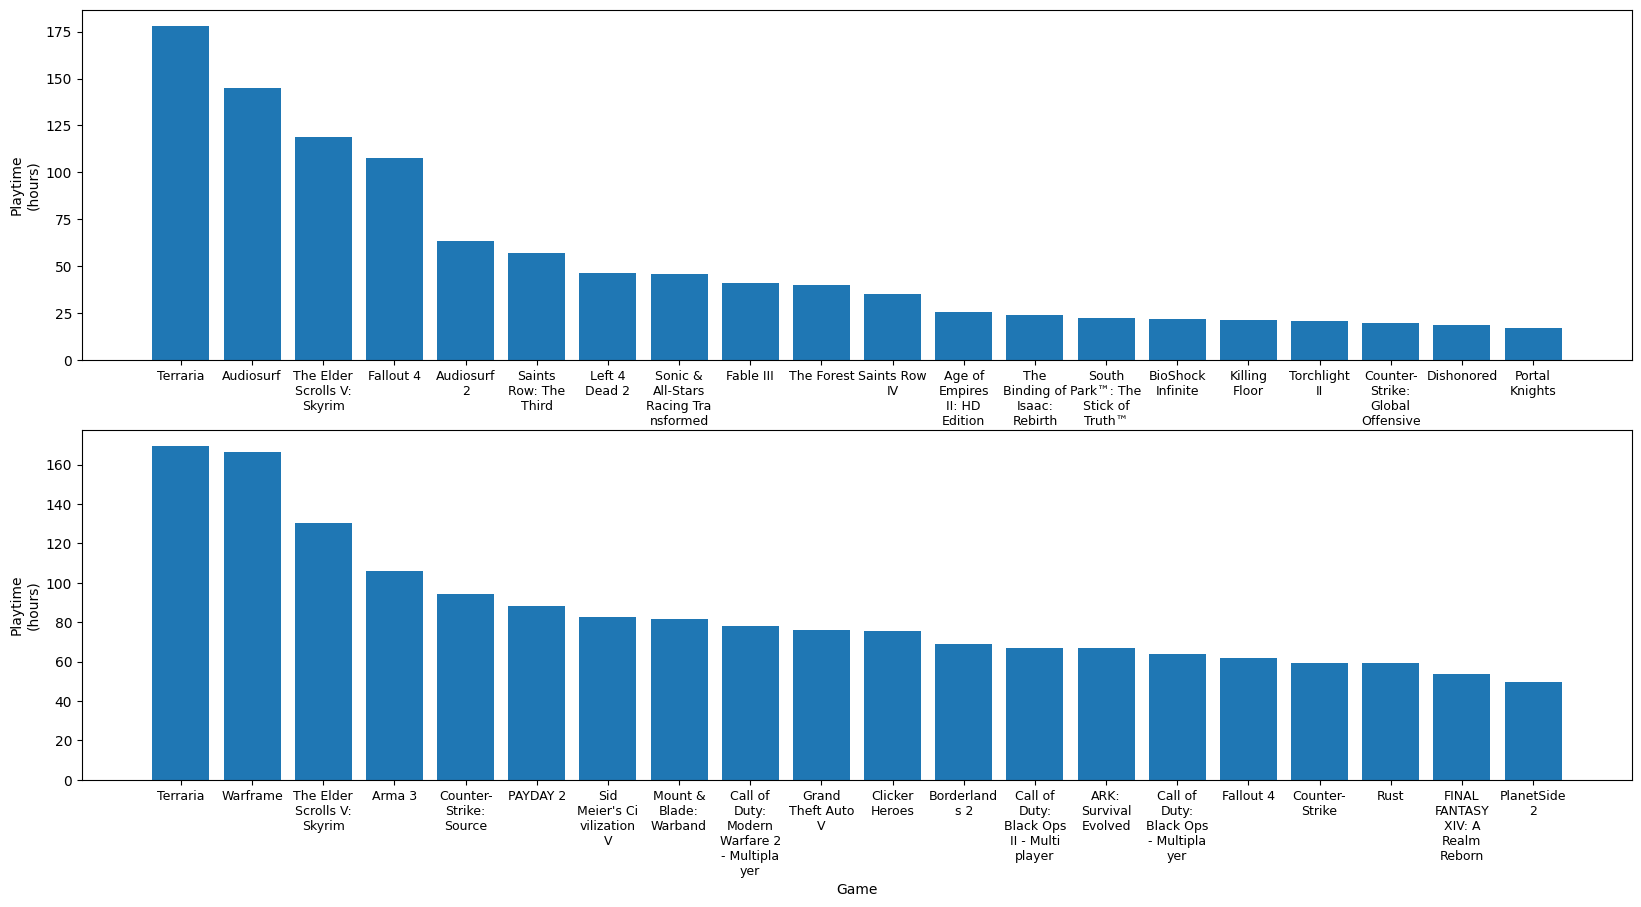

In [6]:
draw_x_gametimes(actual_top_games, pred_top_games)